In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
from experiment import ExperimentEvaluation
import pandas as pd
from IPython.display import display
import itertools
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['text.usetex'] = True

In [2]:
evaluation_paths = glob.glob(".\\results/**cosine_bleu**")

In [3]:
metric_results = []
for evaluation_path in evaluation_paths:
    exp_name, res = ExperimentEvaluation.load_results(evaluation_path)
    vectorizer, vec_dist, text_sim, candidate_count = exp_name.split("_")[:4]
    candidate_count = int(candidate_count.replace("C", ""))
    keys = list(res.keys())
    metric_results.append({"vectorizer": vectorizer, "candidate_count": candidate_count, "vec_dist": vec_dist, "text_sim": text_sim} | {key: res[key] for key in keys})

In [4]:
df = pd.DataFrame(metric_results)
df["exact_match(\%)"] = df.apply(lambda row: row["exact_matches"][1], axis=1)
# df["exact_match_count"] = df.apply(lambda row: row["exact_matches"][0], axis=1)
df = df.round(3)

In [5]:
res_table = df.pivot_table(index="candidate_count", columns="vectorizer")
metrics = res_table.columns.get_level_values(0).unique()

In [6]:
def highlight_max(s):
    is_max = s == s.max()
    return ['color: green' if cell else '' for cell in is_max]

def highlight_min(s):
    is_max = s == s.min()
    return ['color: red' if cell else '' for cell in is_max]

In [11]:
dfs = []
for metric in metrics:
    metric_df = res_table[metric]
    # metric_df["diff"] = round(((metric_df["bert"] - metric_df["bow"]) / metric_df["bow"]) * 100 , 2)
    metric_df = metric_df.T
    metric_df.columns = pd.MultiIndex.from_product([[metric], metric_df.columns])
    dfs.append(metric_df)
merged = dfs[0].merge(dfs[1], left_index=True, right_index=True).merge(dfs[2], left_index=True, right_index=True).round(3)
# merged.columns = pd.MultiIndex.from_product([[1,3,5,10], metrics])
merged

bleu_mean                      exact_match(\%)                \
candidate_count        1      3      5      10              1      3      5    
vectorizer                                                                     
bert                0.127  0.185  0.210  0.241           2.799  3.381  3.638   
bow                 0.117  0.173  0.197  0.227           2.385  2.904  3.034   
doc2vec             0.114  0.172  0.196  0.227           2.145  2.766  2.910   
tfidf               0.116  0.172  0.196  0.227           2.268  2.811  2.970   
word2vec-mean       0.113  0.167  0.191  0.221           2.126  2.552  2.683   

                       execution_time                             
candidate_count     10             1        3        5        10  
vectorizer                                                        
bert             3.788         59.171  103.569  171.812  163.048  
bow              3.181        129.201  176.234  195.284  254.778  
doc2vec          3.091         43.269   94.470  111.282  161.107  
tfidf            3.144        125.494  174.118  176.571  241.050  
word2vec-mean    2.808         38.912   85.153  105.513  145.805

In [23]:
for metric in metrics:
    display(res_table[metric].style.apply(highlight_max, axis = 0).apply(highlight_min, axis = 0).set_caption(metric.title().replace("_", " ")).format(precision=3))

vectorizer,bert,bow,doc2vec,tfidf,word2vec-mean
candidate_count,,,,,
1,0.127,0.117,0.114,0.116,0.113
3,0.185,0.173,0.172,0.172,0.167
5,0.210,0.197,0.196,0.196,0.191
10,0.241,0.227,0.227,0.227,0.221


vectorizer,bert,bow,doc2vec,tfidf,word2vec-mean
candidate_count,,,,,
1,2.799,2.385,2.145,2.268,2.126
3,3.381,2.904,2.766,2.811,2.552
5,3.639,3.034,2.910,2.970,2.683
10,3.788,3.181,3.091,3.144,2.808


vectorizer,bert,bow,doc2vec,tfidf,word2vec-mean
candidate_count,,,,,
1,59.171,129.201,43.269,125.494,38.912
3,103.569,176.234,94.470,174.118,85.153
5,171.811,195.284,111.282,176.571,105.513
10,163.048,254.778,161.107,241.050,145.805


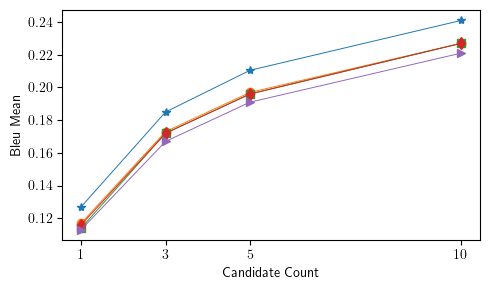

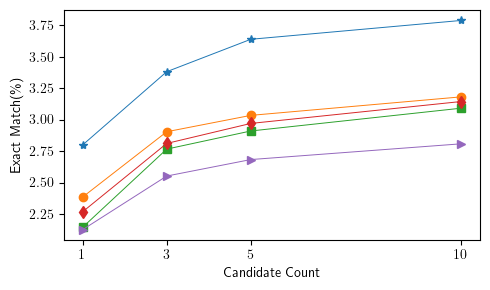

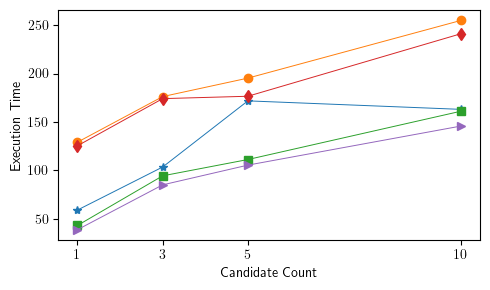

In [29]:
for metric in metrics:
    for m, col in zip('*osd>', res_table[metric]):
        ax = res_table[metric][col].plot(figsize=(5, 3), marker=m, linewidth=0.7)
        ax.set_xticks([1,3,5,10])
        ax.set_xlabel("Candidate Count")
        ax.set_ylabel(metric.title().replace("_", " "))        
        # ax.legend(['Transformer', 'BoW', 'Doc2Vec', 'TF-IDF', "Word2Vec"], frameon=True, facecolor="white", framealpha=1, loc="upper left", fontsize=10, bbox_to_anchor=(1.0, 1))
    plt.tight_layout()
    name = metric.replace("\\", " ")
    # plt.savefig(f'figs/{name}.png', dpi=300)
    plt.show()


In [ ]:
candidate_counts = sorted(list(df["candidate_count"].unique()))
vectorizers = df["vectorizer"].unique()
pairs = itertools.product(vectorizers, candidate_counts)

In [ ]:
frames = []
for vectorizer, candidate_count in pairs:
    fr = df[(df["candidate_count"] == candidate_count) & (df["vectorizer"] == vectorizer)][["bleu_ranged_means"]]
    ex = pd.concat(fr["bleu_ranged_means"].tolist())
    ex["vectorizer"] = vectorizer
    ex["candidate_count"] = candidate_count
    frames.append(ex)

In [ ]:
range_results = pd.concat(frames).pivot_table(index="range", columns=["candidate_count", "vectorizer"], values="bleu")
range_results.style.apply(highlight_max, axis = 1).apply(highlight_min, axis = 1).format(precision=3)

In [ ]:
# ncols = 2
# nrows = 2
# ymin = min(range_results.min()) - 0.02
# ymax = max(range_results.max()) + 0.02
# fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12))
# fig.suptitle('Mean Bleu Scores of Different Candidate Counts', fontsize=14)
# for count, (i, j) in enumerate(itertools.product(range(nrows), range(ncols))):
#     ax = range_results[candidate_counts[count]].plot(ax=axs[i,j],  title=f"Best {candidate_counts[count]}-Candidates", marker="*",  ylim=(ymin, ymax), linewidth=2)
#     ax.set_xlabel("Distance Ranges")
#     ax.set_ylabel("Mean Bleu Score")
#     ax.invert_xaxis()
#     ax.legend(frameon=True, facecolor="white", framealpha=1, loc="upper left", fontsize=10)
# plt.tight_layout()